**Purpose**: This document hopes to address concerns about data loss when merging the 10-K filings + metrics, including:
1. Losing ~30% of the 10-K filings
2. Losing ~5% of our stock metrics

**TL;DR** (read the document for graphs/methods):

* **10-K Filings**
     - 5% of 10-k filings are lost outright because they have CIKs not found in metrics
     - Of the other 95%, 16% of the time we have data for 10-K filings but not the predictions for a given (CIK,Year). This accounts for 15% (.95 * .16) of initial 10-k filing rows.
     - Overall, 20% of the loss is due to there not being matching data

* **Stock Metrics**
    - Around 0.5% of the metrics are lost because the CIK is not found in 10-K filings
    - Of the other 99.5%, 2.5%-4.5% (Depending on what column we consider to be the year) of the time we have data for the metric but not the 10-K for a given (CIK,Year)
    - Overall, 3%-5% of the loss is due to there not being matching data
    
- Joining on different column combinations (using CIK + filing_date, year, or filing_year) makes little difference.
- During preprocessing, grouping by CIK and using latest record removes 2% of the text rows. Even if we picked the wrong record every time this wouldn't be significant enough to explain the rest of our errors.

**Maybe a different way of combining this data is needed. Still 10% of the 10-K filings and 0%-2% of the stock metrics unaccounted for.**
- Note that in this code metrics/prediction refer to the stock events, while 10-k/text refer to the 10-k data

In [1]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_numeric, strip_punctuation, strip_short, stem_text
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess 10-K filings

In [2]:
def output_loss_metrics(pre_sizes, post_sizes):
    # Output some metrics on data-loss
    for pre_size, post_size, year in zip(pre_sizes, post_sizes, list(range(2009,2021))):
        num_lost = pre_size - post_size
        percent_lost = float(num_lost) / float(pre_size)
        display("{:n} lost {:.2%}, {} rows total".format(year, percent_lost, num_lost))

    num_lost = sum(pre_sizes) - sum(post_sizes)
    percent_lost = float(num_lost) / float(sum(pre_sizes))
    display("In total lost {:.2%}, {} rows total".format(percent_lost, num_lost))
    
# Dirty logic for collapsing groups. Reformat as needed - currently pretty dumb
def collapse_cik_groups(grp):
    if len(grp) > 1:
        """ If the 1a and 7 text is the same, take the most recent (regardless of ticker)"""
        if (grp.iloc[0,3] == grp["item1a_risk"]).all() and (grp.iloc[0,3] == grp["item7_mda"]).all():
            # Seems like its sorted by filing_date originally - just take the last
            return grp.iloc[-1,:]
        else:
            """For now, just return the most recent"""
            return grp.iloc[-1,:]
    else:
        return grp.squeeze()

In [3]:
# Load CSV
data_by_year = {}
relevant_cols = ["cik", "ticker", "filing_date", "item1a_risk", "item7_mda"]
path = "../Files/"

pre_sizes = []
post_drop_na_sizes = []
post_drop_dup_sizes = []

for year in range(2009,2021):
    data_by_year[year] = pd.read_csv(path + str(year) + ".csv", usecols=relevant_cols)
    pre_sizes.append(len(data_by_year[year]))
    data_by_year[year] = data_by_year[year].dropna(subset=['cik', 'item1a_risk', 'item7_mda', 'filing_date'])
    post_drop_na_sizes.append(len(data_by_year[year]))
    data_by_year[year] = data_by_year[year].drop_duplicates()
    post_drop_dup_sizes.append(len(data_by_year[year]))
    data_by_year[year]["filing_date"] = pd.to_datetime(data_by_year[year]["filing_date"])
    data_by_year[year]["year"] = year
    data_by_year[year]["filing_year"] =  pd.DatetimeIndex(data_by_year[year]["filing_date"]).year

display("After dropping N/A on (cik,filing_date, 1a, 7)")
output_loss_metrics(pre_sizes, post_drop_na_sizes)
display("After dropping duplicates")
output_loss_metrics(post_drop_na_sizes, post_drop_dup_sizes)

'After dropping N/A on (cik,filing_date, 1a, 7)'

'2009 lost 3.32%, 32 rows total'

'2010 lost 3.72%, 139 rows total'

'2011 lost 3.05%, 117 rows total'

'2012 lost 2.96%, 116 rows total'

'2013 lost 2.60%, 104 rows total'

'2014 lost 2.49%, 103 rows total'

'2015 lost 2.50%, 107 rows total'

'2016 lost 2.40%, 100 rows total'

'2017 lost 2.35%, 98 rows total'

'2018 lost 2.39%, 100 rows total'

'2019 lost 2.04%, 85 rows total'

'2020 lost 6.22%, 123 rows total'

'In total lost 2.81%, 1224 rows total'

'After dropping duplicates'

'2009 lost 15.02%, 140 rows total'

'2010 lost 10.77%, 387 rows total'

'2011 lost 10.35%, 385 rows total'

'2012 lost 10.78%, 410 rows total'

'2013 lost 11.78%, 459 rows total'

'2014 lost 12.23%, 493 rows total'

'2015 lost 12.61%, 526 rows total'

'2016 lost 12.44%, 505 rows total'

'2017 lost 13.90%, 565 rows total'

'2018 lost 14.79%, 605 rows total'

'2019 lost 15.17%, 619 rows total'

'2020 lost 4.26%, 79 rows total'

'In total lost 12.23%, 5173 rows total'

In [4]:
pre_grouping_sizes = []
post_grouping_sizes = []

for year in range(2009,2021):
    pre_grouping_sizes.append(len(data_by_year[year]))
    data_by_year[year] = data_by_year[year].groupby("cik").apply(lambda grp: collapse_cik_groups(grp)).reset_index(drop=True)
    post_grouping_sizes.append(len(data_by_year[year])) 

output_loss_metrics(pre_grouping_sizes, post_grouping_sizes)

'2009 lost 1.77%, 14 rows total'

'2010 lost 1.59%, 51 rows total'

'2011 lost 1.74%, 58 rows total'

'2012 lost 1.65%, 56 rows total'

'2013 lost 1.75%, 60 rows total'

'2014 lost 1.92%, 68 rows total'

'2015 lost 2.09%, 76 rows total'

'2016 lost 2.05%, 73 rows total'

'2017 lost 2.37%, 83 rows total'

'2018 lost 2.47%, 86 rows total'

'2019 lost 2.51%, 87 rows total'

'2020 lost 3.49%, 62 rows total'

'In total lost 2.08%, 774 rows total'

In [5]:
# Concat all dataframes into a single one
text_dfs = pd.concat(data_by_year.values(), ignore_index=True)
text_dfs.head()

,cik,ticker,filing_date,item1a_risk,item7_mda,year,filing_year
0,1750,AIR,2009-07-16,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2009,2009
1,2034,ACET,2009-09-11,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2009,2009
2,2491,BYI,2009-08-20,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2009,2009
3,2969,APD,2009-11-25,>ITEM 1A. RISK FACTORS The Company operates in...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2009,2009
4,3545,ALCO,2009-12-14,>Item 1A. Risk Factors. Alico s operations inv...,>Item 7. Management s Discussion and Analysis ...,2009,2009


# Load target data

In [6]:
# Load predictions

relevant_cols = ["PERMID", "CIK", "Ticker", "year", "FilingDate", "company_name", "Dividend Payer", "DPS growth", "DPS cut", "zEnvironmental", "dEnvironmental", "sector"]
predictions = pd.read_excel(path + "predictions.xlsx", sheet_name="data", skiprows=32, usecols=relevant_cols)
predictions.columns = ["perm_id", "cik", "ticker", "year", "filing_date", "company_name", "is_dividend_payer", "dps_change", "is_dps_cut", "z_environmental", "d_environmental", "sector"]
predictions['perm_id'] = predictions['perm_id'].str.replace(r"[^0-9]",'')
predictions["filing_date"] = pd.to_datetime(predictions["filing_date"])
predictions["filing_year"] = pd.DatetimeIndex(predictions["filing_date"]).year

""" Difference in filing_date and the year (ticker AA  has 2016 w/ 2017 filing)"""
predictions.head()

,perm_id,cik,ticker,year,filing_date,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year
0,229,1090872,A,2012,2012-12-20,AGILENT TECHNOLOGIES INC,1.0,0.421053,0.0,2.449925,-1.408006,Health Care,2012
1,229,1090872,A,2013,2013-12-19,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,1.666993,1.117957,Health Care,2013
2,229,1090872,A,2014,2014-12-22,AGILENT TECHNOLOGIES INC,1.0,-0.275862,1.0,2.154238,-0.193752,Health Care,2014
3,229,1090872,A,2015,2015-12-21,AGILENT TECHNOLOGIES INC,1.0,0.139535,0.0,2.069083,0.039619,Health Care,2015
4,229,1090872,A,2016,2016-12-20,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,2.087030,-0.112717,Health Care,2016


# Explore data pre-merge

**Question** : Are we losing data because there isn't as much CIK overlap between the two datasets? Lets find all of the CIKs that show up in both datasets and try to figure out if the issue is the data itself or the way it is being processed.


**Key Takeaways**:
- 10% of the unique CIKs found in 10-k filings cannot be found in the metrics. This is unlikely to be due to pre-processing because we group by CIK and only remove rows that are duplicates. This accounts for 5% of the actual 10-k data in terms of rows. Unless we have some 3rd data source that can help us figure out changing ticker CIKs, it is unlikely this can be changed.
- For CIKs that are found in both, existence of text data and existence of metrics data agree about 80% of the time. This means that 80% of the time we either do not have data for either, or have data for both.

In [7]:
pred_ciks = set(predictions.cik)
text_ciks = set(text_dfs.cik)

intersection = pred_ciks.intersection(text_ciks)
union = pred_ciks.union(text_ciks)
text_only = text_ciks.difference(pred_ciks)
pred_only = pred_ciks.difference(text_ciks)


display("Total of {:n} unique CIKs".format(len(union)))
display("# and % of CIKs in intersection: ({:n},{:.2%})".format(len(intersection), float(len(intersection)) / float(len(union)))) 
display("# and % of CIKs only found in 10-K: ({:n},{:.2%})".format(len(text_only), float(len(text_only)) / float(len(union))))
display("# and % of CIKs only found in metrics: ({:n},{:.2%})".format(len(pred_only), float(len(pred_only)) / float(len(union))))


leftover_textdf = text_dfs[text_dfs["cik"].isin(text_only)]
leftover_preddf = predictions[predictions["cik"].isin(pred_only)]
text_loss_percent = float(len(leftover_textdf)) / float(len(text_dfs))
metric_loss_percent = float(len(leftover_preddf)) / float(len(predictions))

display("CIKs that only appear in the text account for {:.2%} of the text data".format(text_loss_percent))
display("CIKs that only appear in the prediction metrics account for {:.2%} of the metrics data".format(metric_loss_percent))

common_ciks = sorted(list(intersection))

'Total of 5262 unique CIKs'

'# and % of CIKs in intersection: (4645,88.27%)'

'# and % of CIKs only found in 10-K: (595,11.31%)'

'# and % of CIKs only found in metrics: (22,0.42%)'

'CIKs that only appear in the text account for 4.92% of the text data'

'CIKs that only appear in the prediction metrics account for 0.39% of the metrics data'

In [8]:
""" Define this method to be used below

    For both the 10-K text and metrics for prediction, lets create a 2D binary array where the value
    is 1 if there is a datum for that (cik,year) and 0 otherwise. This 2D array has CIKs by row and year by column.
    Return these binary arrays as well as their logical and (meaning data exists for both) as well as having the
    same value (Not a mismatch)
"""
def find_valid(year_start, year_end, text_col, metrics_col):
    num_years = year_end - year_start + 1
    valid_text = []
    valid_metrics = []
    
    # Find rows in our year range
    textDF = text_dfs[(text_dfs[text_col] >= year_start) & (text_dfs[text_col] <= year_end)]
    metricsDF = predictions[(predictions[metrics_col] >= year_start) & (predictions[metrics_col] <= year_end) ]
    
    # Create the binary heatmap of datum existence
    for cik in common_ciks: #Sorted list of CIKs
        text_binary = [0] * num_years
        
        # Set value to 1 in locations where we have data
        for year in textDF[textDF.cik == cik].loc[:,text_col]:
            text_binary[year - year_start] = 1
        valid_text.append(text_binary)
        
        metric_binary = [0] * num_years
        for year in metricsDF[metricsDF.cik == cik].loc[:,metrics_col]:
            metric_binary[year - year_start] = 1
        valid_metrics.append(metric_binary)
        
    valid_text = np.array(valid_text)
    valid_metrics = np.array(valid_metrics)
    binary_both = np.logical_and(valid_text, valid_metrics)
    binary_same = valid_text == valid_metrics
    binary_text_not_metrics = np.logical_and(valid_text, 1-valid_metrics)
    binary_metrics_not_text = np.logical_and(1-valid_text, valid_metrics)
    
    total_datapoints = float(num_years * len(common_ciks))
    display("# and % of present entries in text: ({:n},{:.2%})".format(valid_text.sum(), float(valid_text.sum()) / total_datapoints)) 
    display("# and % of present entries in metrics: ({:n},{:.2%})".format(valid_metrics.sum(), float(valid_metrics.sum()) / total_datapoints)) 
    display("# and % of present entries in text & metrics: ({:n},{:.2%})".format(binary_both.sum(), float(binary_both.sum()) / total_datapoints))
    display("# and % of entries in text & metrics that have the same value: ({:n},{:.2%})".format(binary_same.sum(), float(binary_same.sum()) / total_datapoints))
    display("% of entries where we have a value for the text but not metrics {:.2%}".format(float(binary_text_not_metrics.sum()) / total_datapoints))
    display("% of entries where we have a value for the metrics but not text {:.2%}".format(float(binary_metrics_not_text.sum()) / total_datapoints))
    
    return (valid_text, valid_metrics, binary_both, binary_same)

def plot_heatmap(binary_data, title, axis, start_year=2009):
    sns.heatmap(data=binary_data, ax=axis)
    axis.set_title(title)
    axis.set_xlabel("Years")
    axis.set_xticklabels([i for i in list(range(start_year,start_year + len(binary_data[0])))])
    axis.set_ylabel("CIK Index (Sorted)")

### Heatmap when (Text,Metrics) use years from columns ["year","year"] for 2009-2020 on shared CIKs

'# and % of present entries in text: (34563,62.01%)'

'# and % of present entries in metrics: (26929,48.31%)'

'# and % of present entries in text & metrics: (25504,45.76%)'

'# and % of entries in text & metrics that have the same value: (45256,81.19%)'

'% of entries where we have a value for the text but not metrics 16.25%'

'% of entries where we have a value for the metrics but not text 2.56%'

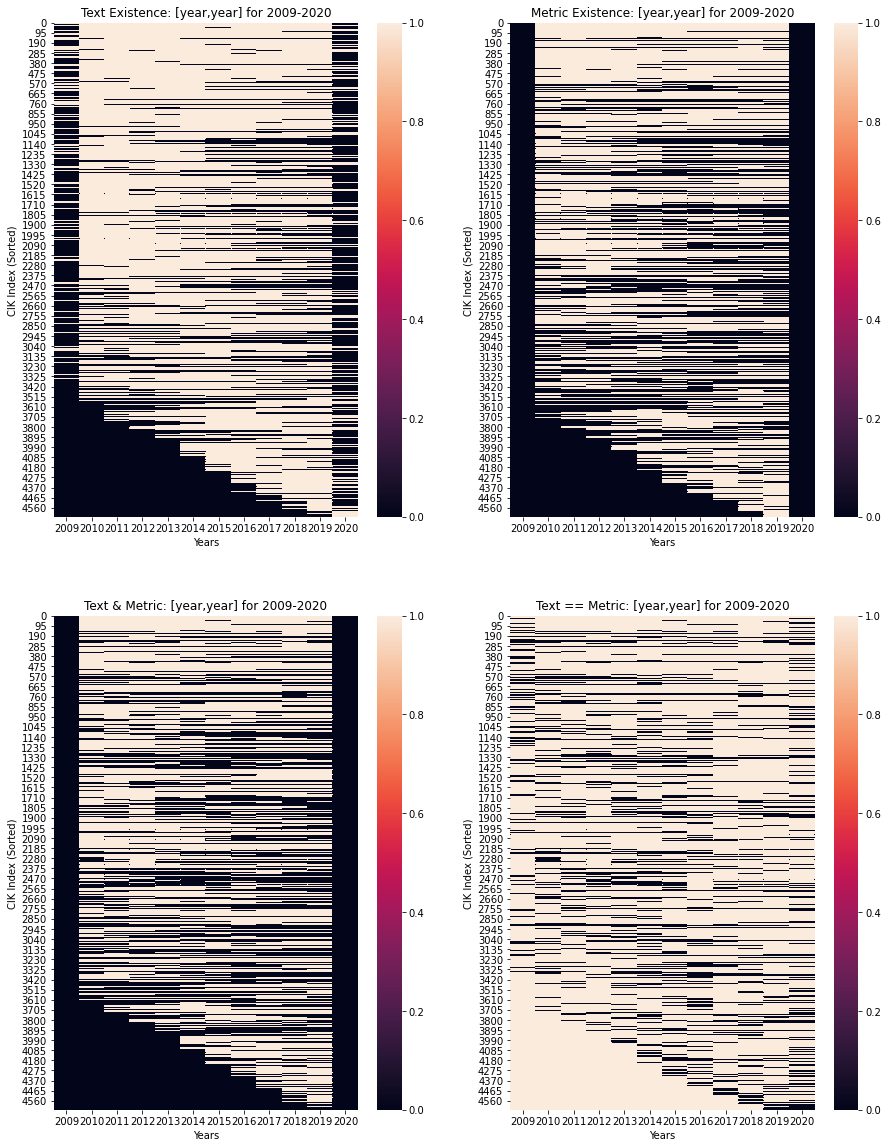

In [9]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "year", "year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,year] for 2009-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,year] for 2009-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,year] for 2009-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,year] for 2009-2020", axs[1,1])

### Heatmap when (Text,Metrics) use years from columns ["year","filing_year"] 2009-2020

'# and % of present entries in text: (34563,62.01%)'

'# and % of present entries in metrics: (26904,48.27%)'

'# and % of present entries in text & metrics: (25037,44.92%)'

'# and % of entries in text & metrics that have the same value: (44347,79.56%)'

'% of entries where we have a value for the text but not metrics 17.09%'

'% of entries where we have a value for the metrics but not text 3.35%'

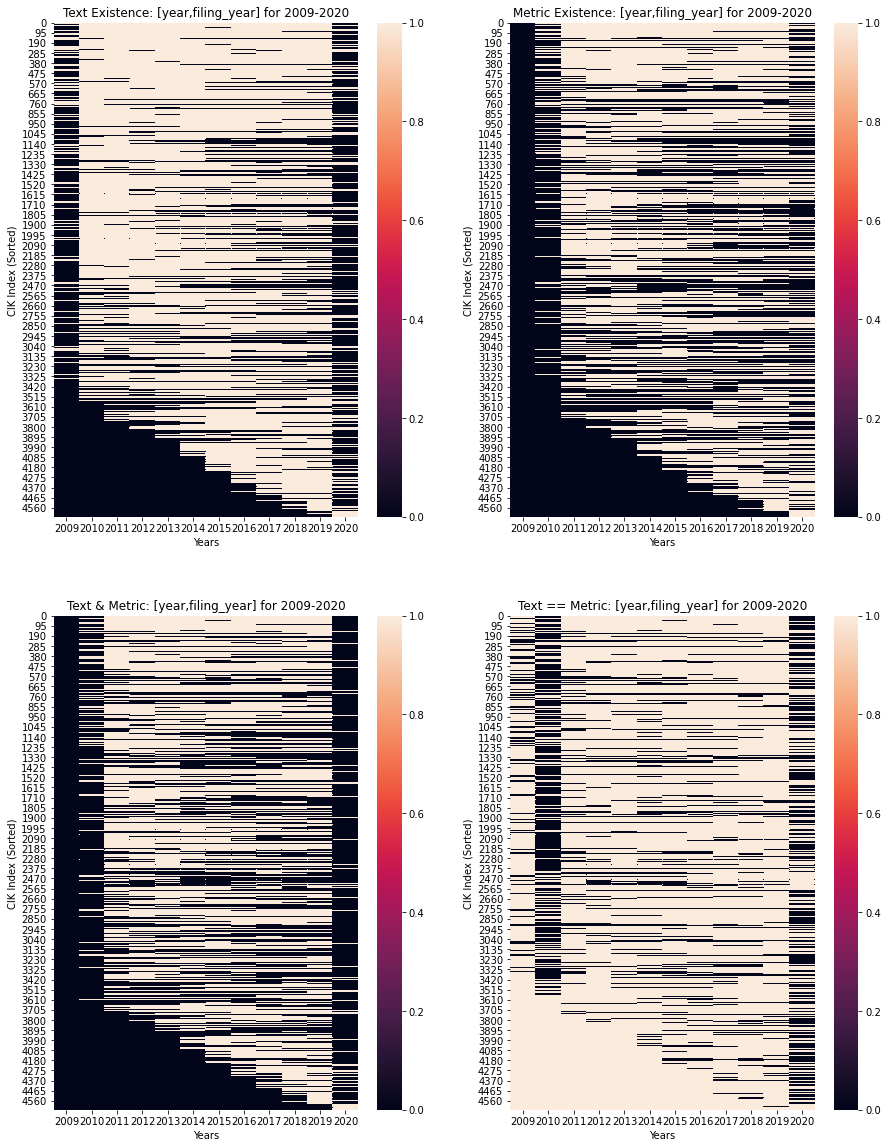

In [10]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "year", "filing_year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,filing_year] for 2009-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,filing_year] for 2009-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,filing_year] for 2009-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,filing_year] for 2009-2020", axs[1,1])

### Heatmap when (Text,Metrics) use years from columns ["filing_year","year"] 2009-2020

'# and % of present entries in text: (34563,62.01%)'

'# and % of present entries in metrics: (26929,48.31%)'

'# and % of present entries in text & metrics: (25504,45.76%)'

'# and % of entries in text & metrics that have the same value: (45256,81.19%)'

'% of entries where we have a value for the text but not metrics 16.25%'

'% of entries where we have a value for the metrics but not text 2.56%'

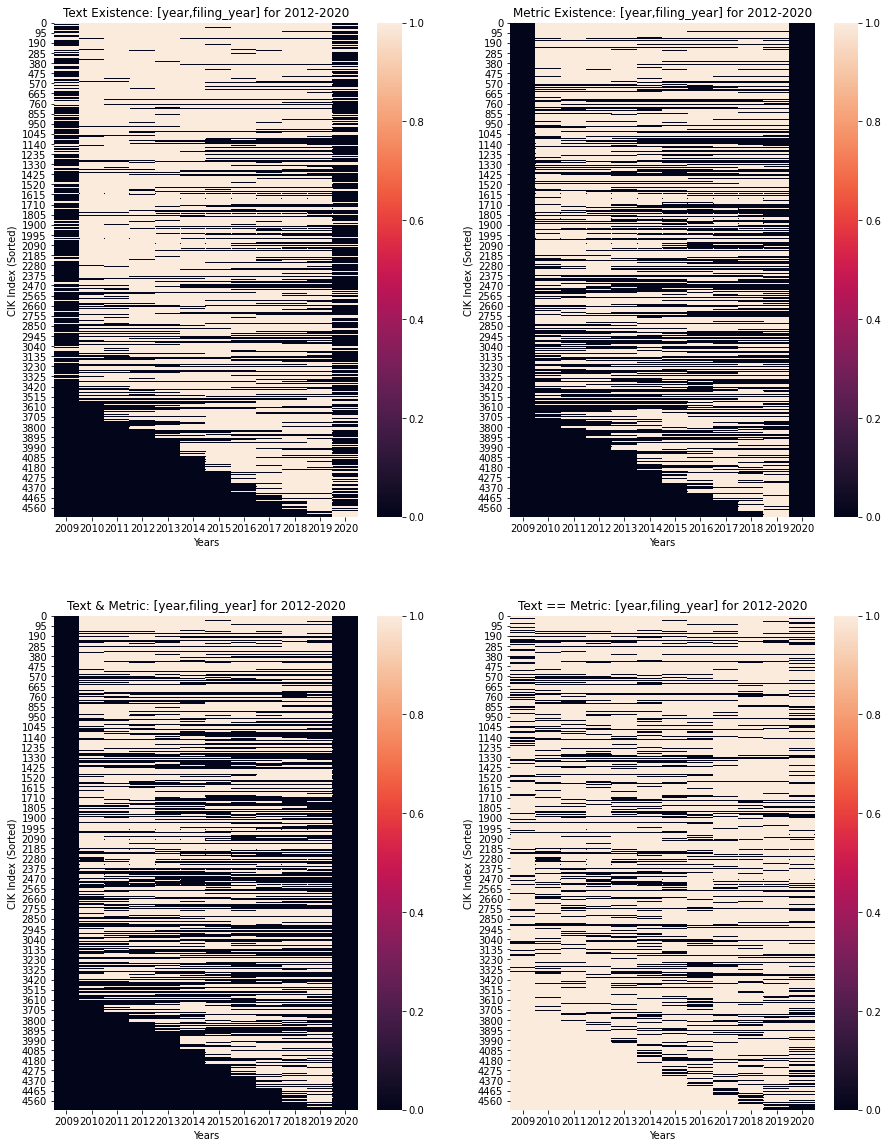

In [11]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "filing_year", "year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,filing_year] for 2012-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,filing_year] for 2012-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,filing_year] for 2012-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,filing_year] for 2012-2020", axs[1,1])    

### Heatmap when (Text,Metrics) use years from columns ["filing_year","filing_year"] 2009-2020

'# and % of present entries in text: (34563,62.01%)'

'# and % of present entries in metrics: (26904,48.27%)'

'# and % of present entries in text & metrics: (25037,44.92%)'

'# and % of entries in text & metrics that have the same value: (44347,79.56%)'

'% of entries where we have a value for the text but not metrics 17.09%'

'% of entries where we have a value for the metrics but not text 3.35%'

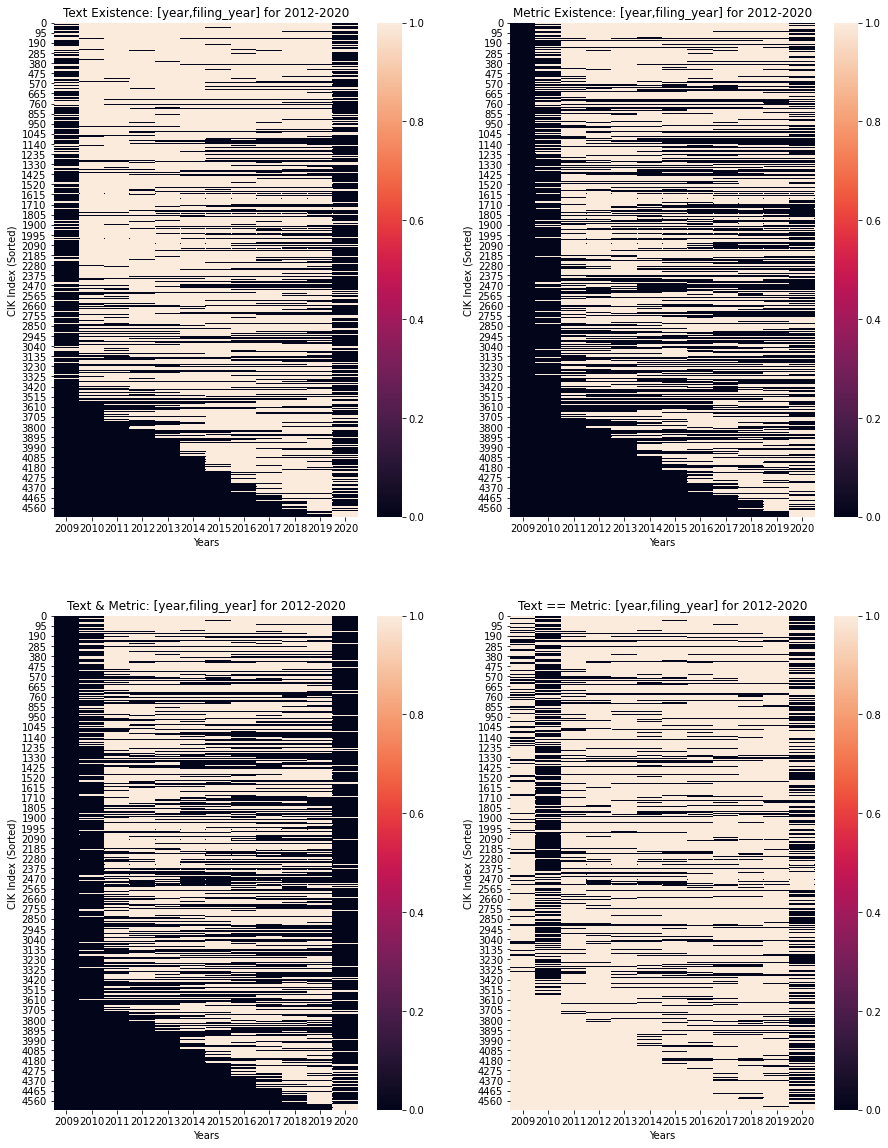

In [12]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "filing_year", "filing_year")

fig, axs = plt.subplots(2,2, figsize=(15,20))
plot_heatmap(binary_text, "Text Existence: [year,filing_year] for 2012-2020", axs[0,0])
plot_heatmap(binary_metrics, "Metric Existence: [year,filing_year] for 2012-2020", axs[0,1])
plot_heatmap(binary_both, "Text & Metric: [year,filing_year] for 2012-2020", axs[1,0])
plot_heatmap(binary_same, "Text == Metric: [year,filing_year] for 2012-2020", axs[1,1])    

# Can merging on different columns help?

Columns of text and metrics include ["cik", "filing_date", "filing_year" "year"]. For text, year is derived from the name of the file (e.g. 2012.csv) while . Metric columns include ["cik", "filing_date", "filing_year", "year"] where filing_year is just the year from filing_date.
- There are 6 different orientations to try (filing_date only matches with itself and we always use CIK)

In [13]:
def merge_stats(text_cols, pred_cols):
    result = pd.merge(text_dfs, predictions, left_on=text_cols, right_on=pred_cols)

    num_result = float(len(result))
    num_text = len(text_dfs)
    num_pred = len(predictions)
    num_text_lost = float(num_text - num_result)
    num_pred_lost = float(num_pred - num_result)

    ticker_mismatch = result["ticker_x"] != result["ticker_y"]
    
    # filing_date_x/y don't exist if we merge on it. Make mismatch = 0
    if ("filing_date" in text_cols) or ("filing_date" in pred_cols):
        filing_date_mismatch = np.array([0] * int(num_result))        
    else:
        filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
        
    ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
    ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

    display("Merging on CIK and " + "(" + text_cols[1] + "," + pred_cols[1] +") for (Text,pred)")
    display("     # and % of 10-K filings lost: ({:n},{:.2%})".format(num_text_lost, num_text_lost/ num_text))
    display("     # and % of stock events lost: ({:n},{:.2%})".format(num_pred_lost, num_pred_lost/ num_pred))
    display("     # and % of ticker mismatches: ({:n},{:.2%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
    display("     # and % of filing date mismatches: ({:n},{:.2%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
    display("     # and % of ticker and filing date mismatches: ({:n},{:.2%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
    display("     # and % of ticker or filing date mismatches: ({:n},{:.2%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

In [14]:
merge_stats(["cik", "filing_date"], ["cik", "filing_date"])
merge_stats(["cik", "filing_year"], ["cik", "filing_year"])
merge_stats(["cik", "year"], ["cik", "year"])
merge_stats(["cik", "year"], ["cik", "filing_year"])
merge_stats(["cik", "filing_year"], ["cik", "year"])

'Merging on CIK and (filing_date,filing_date) for (Text,pred)'

'     # and % of 10-K filings lost: (11316,31.13%)'

'     # and % of stock events lost: (2000,7.40%)'

'     # and % of ticker mismatches: (598,2.39%)'

'     # and % of filing date mismatches: (0,0.00%)'

'     # and % of ticker and filing date mismatches: (0,0.00%)'

'     # and % of ticker or filing date mismatches: (598,2.39%)'

'Merging on CIK and (filing_year,filing_year) for (Text,pred)'

'     # and % of 10-K filings lost: (11289,31.06%)'

'     # and % of stock events lost: (1973,7.30%)'

'     # and % of ticker mismatches: (599,2.39%)'

'     # and % of filing date mismatches: (27,0.11%)'

'     # and % of ticker and filing date mismatches: (1,0.00%)'

'     # and % of ticker or filing date mismatches: (625,2.49%)'

'Merging on CIK and (year,year) for (Text,pred)'

'     # and % of 10-K filings lost: (10847,29.84%)'

'     # and % of stock events lost: (1531,5.66%)'

'     # and % of ticker mismatches: (550,2.16%)'

'     # and % of filing date mismatches: (19766,77.50%)'

'     # and % of ticker and filing date mismatches: (412,1.62%)'

'     # and % of ticker or filing date mismatches: (19904,78.04%)'

'Merging on CIK and (year,filing_year) for (Text,pred)'

'     # and % of 10-K filings lost: (11289,31.06%)'

'     # and % of stock events lost: (1973,7.30%)'

'     # and % of ticker mismatches: (599,2.39%)'

'     # and % of filing date mismatches: (27,0.11%)'

'     # and % of ticker and filing date mismatches: (1,0.00%)'

'     # and % of ticker or filing date mismatches: (625,2.49%)'

'Merging on CIK and (filing_year,year) for (Text,pred)'

'     # and % of 10-K filings lost: (10847,29.84%)'

'     # and % of stock events lost: (1531,5.66%)'

'     # and % of ticker mismatches: (550,2.16%)'

'     # and % of filing date mismatches: (19766,77.50%)'

'     # and % of ticker and filing date mismatches: (412,1.62%)'

'     # and % of ticker or filing date mismatches: (19904,78.04%)'

In [15]:
result = pd.merge(text_dfs, predictions, on=["cik", "filing_date"])

In [16]:
result.head()

,cik,ticker_x,filing_date,item1a_risk,item7_mda,year_x,filing_year_x,perm_id,ticker_y,year_y,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year_y
0,1750,AIR,2010-07-16,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2010,2010,4332,AIR,2010,AAR CORP,0.0,2.000000,NaN,NaN,NaN,Industrials,2010
1,2034,ACET,2010-09-10,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2010,2010,2883,ACET,2010,ACETO CORP,1.0,0.000000,0.0,NaN,NaN,Industrials,2010
2,2491,BYI,2010-08-26,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2010,2010,2791,BYI,2010,BALLY TECHNOLOGIES INC,0.0,NaN,NaN,NaN,NaN,Tech,2010
3,2969,APD,2010-11-23,>ITEM 1A. RISK FACTORS You should read the fol...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2010,2010,2799,APD,2010,AIR PRODUCTS & CHEMICALS INC,1.0,0.149398,0.0,0.620576,-1.857054,Commodities,2010
4,3545,ALCO,2010-12-14,>Item 1A. Risk Factors. Alico s operations inv...,>Item 7. Management s Discussion and Analysis ...,2010,2010,1824,ALCO,2010,ALICO INC,1.0,0.181818,0.0,NaN,NaN,Consumer,2010


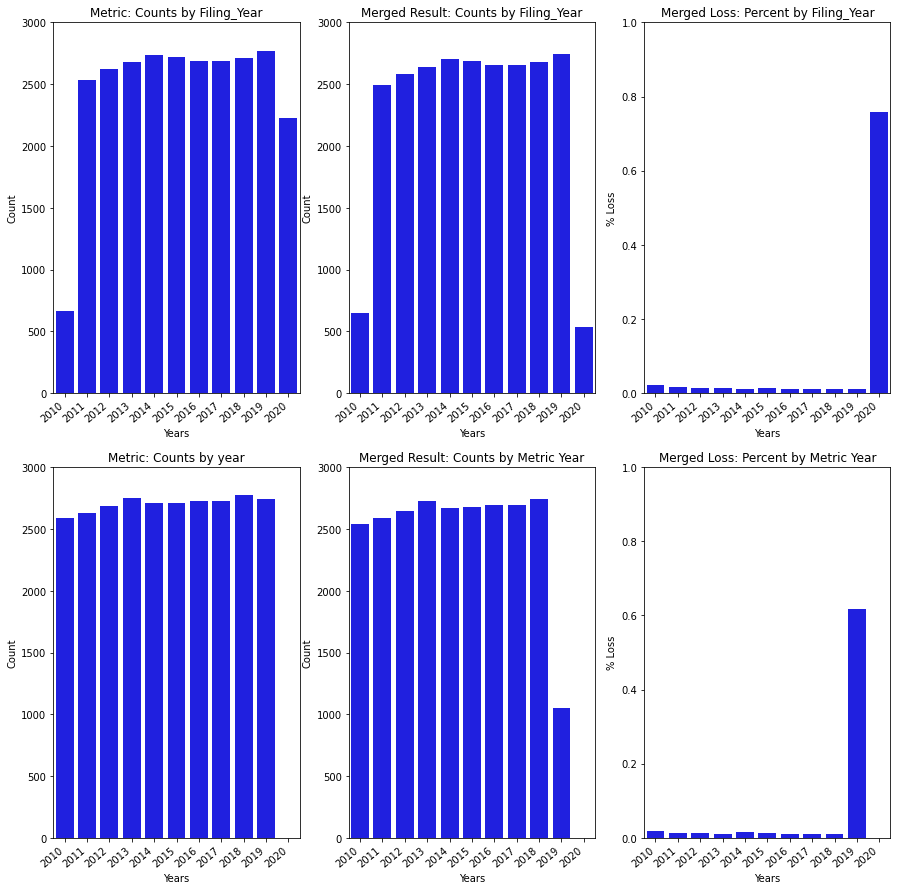

In [27]:
# Merge on filing_date
result = pd.merge(text_dfs, predictions, on=["cik", "filing_date"])
fig, axs = plt.subplots(2,3, figsize=(15,15))



metrics_filing_year = predictions["filing_year"].value_counts().sort_index()
metrics_year = predictions["year"].value_counts().append(pd.Series({2020:0}, index=[2020])).sort_index()

result_filing_year = pd.DatetimeIndex(result["filing_date"]).year.value_counts().sort_index()
result_year_10k = result["year_x"].value_counts().sort_index()
result_year_metrics = result["year_y"].value_counts().append(pd.Series({2020:0}, index=[2020])).sort_index()

loss_filing_year = (metrics_filing_year - result_filing_year)/metrics_filing_year
loss_year_10k = (metrics_year - result_year_10k) / metrics_year
loss_year_metrics = (metrics_year - result_year_metrics) / metrics_year

sns.barplot(x=metrics_filing_year.index, y=metrics_filing_year.values, color='b', ax=axs[0,0])
axs[0,0].set_title("Metric: Counts by Filing_Year")
sns.barplot(x=result_filing_year.index, y=result_filing_year.values, color='b', ax=axs[0,1])
axs[0,1].set_title("Merged Result: Counts by Filing_Year")
sns.barplot(x=loss_filing_year.index, y=loss_filing_year.values, color='b', ax=axs[0,2])
axs[0,2].set_title("Merged Loss: Percent by Filing_Year")


# sns.barplot(x=metrics_year.index, y=metrics_year.values, color='b', ax=axs[1,0])
# axs[1,0].set_title("Metric: Counts by year")
# sns.barplot(x=result_year_10k.index, y=result_year_10k.values, color='b', ax=axs[1,1])
# axs[1,1].set_title("Merged Result: Counts by 10K Year")
# sns.barplot(x=loss_year_10k.index, y=loss_year_10k.values, color='b', ax=axs[1,2])
# axs[1,2].set_title("Merged Loss: Percent by 10K Year")

sns.barplot(x=metrics_year.index, y=metrics_year.values, color='b', ax=axs[1,0])
axs[1,0].set_title("Metric: Counts by year")
sns.barplot(x=result_year_metrics.index, y=result_year_metrics.values, color='b', ax=axs[1,1])
axs[1,1].set_title("Merged Result: Counts by Metric Year")
sns.barplot(x=loss_year_metrics.index, y=loss_year_metrics.values, color='b', ax=axs[1,2])
axs[1,2].set_title("Merged Loss: Percent by Metric Year")


for i in range(0,2):
    for j in range(0,3):
        axs[i,j].set_xlabel("Years")
        axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=40, ha="right")
        if j == 2:
            axs[i,j].set(ylim=(0, 1.0))
            axs[i,j].set_ylabel("% Loss")
        else:
            axs[i,j].set(ylim=(0, 3000))
            axs[i,j].set_ylabel("Count")

plt.savefig('filing_date_join_stats.png')

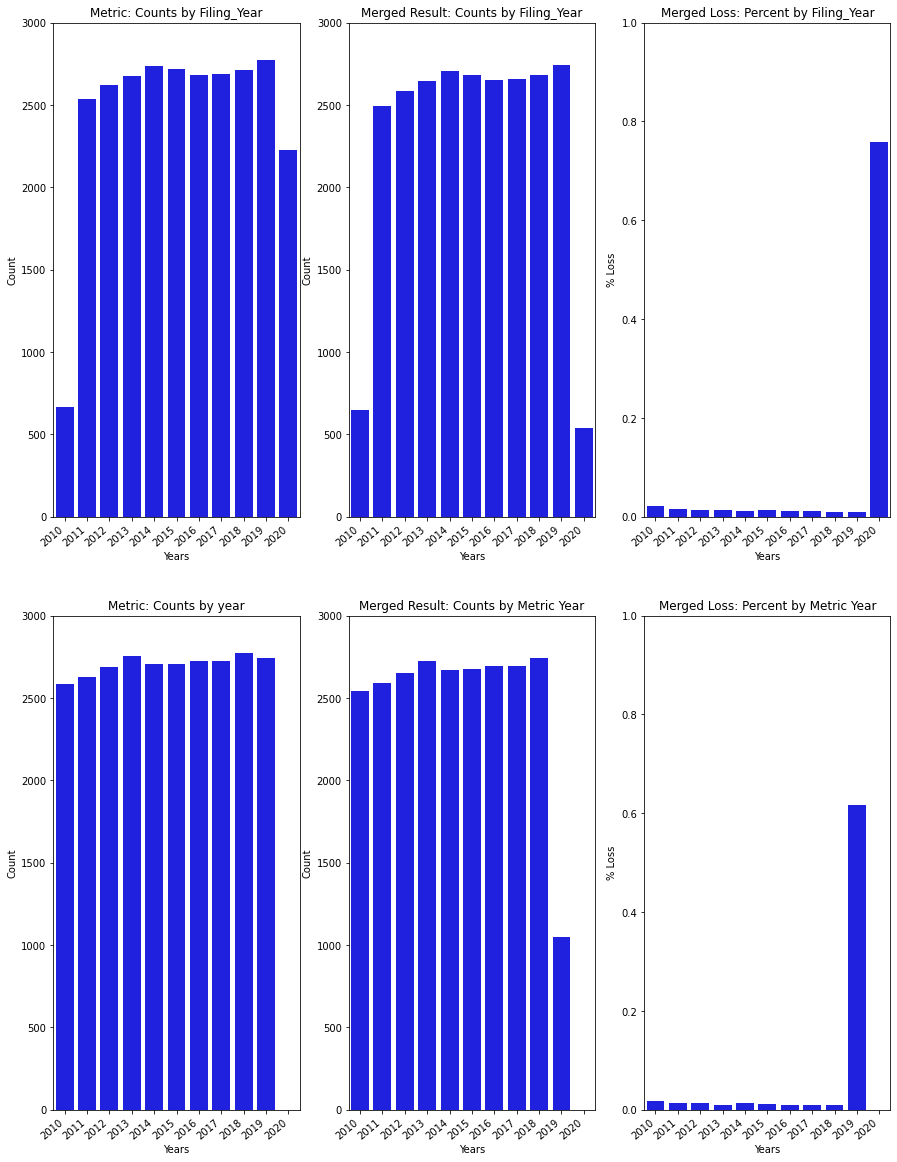

In [28]:
# Merge on year
result = pd.merge(text_dfs, predictions, on=["cik", "year"])
fig, axs = plt.subplots(2,3, figsize=(15,20))

metrics_filing_year = predictions["filing_year"].value_counts().sort_index()
metrics_year = predictions["year"].value_counts().append(pd.Series({2020:0}, index=[2020])).sort_index()

result_year = result["year"].value_counts().sort_index()
result_filing_year_metrics = result["filing_year_y"].value_counts().sort_index()


#loss_filing_year_10k = (metrics_filing_year - result_filing_year_10k) / metrics_filing_year
loss_filing_year_metrics = (metrics_filing_year - result_filing_year_metrics) / metrics_filing_year
loss_year = (metrics_year - result_year) / metrics_year

sns.barplot(x=metrics_filing_year.index, y=metrics_filing_year.values, color='b', ax=axs[0,0])
axs[0,0].set_title("Metric: Counts by Filing_Year")
sns.barplot(x=result_filing_year.index, y=result_filing_year.values, color='b', ax=axs[0,1])
axs[0,1].set_title("Merged Result: Counts by Filing_Year")
sns.barplot(x=loss_filing_year.index, y=loss_filing_year.values, color='b', ax=axs[0,2])
axs[0,2].set_title("Merged Loss: Percent by Filing_Year")


sns.barplot(x=metrics_year.index, y=metrics_year.values, color='b', ax=axs[1,0])
axs[1,0].set_title("Metric: Counts by year")
sns.barplot(x=result_year_metrics.index, y=result_year_metrics.values, color='b', ax=axs[1,1])
axs[1,1].set_title("Merged Result: Counts by Metric Year")
sns.barplot(x=loss_year_metrics.index, y=loss_year_metrics.values, color='b', ax=axs[1,2])
axs[1,2].set_title("Merged Loss: Percent by Metric Year")


for i in range(0,2):
    for j in range(0,3):
        axs[i,j].set_xlabel("Years")
        axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=40, ha="right")
        if j == 2:
            axs[i,j].set(ylim=(0, 1.0))
            axs[i,j].set_ylabel("% Loss")
        else:
            axs[i,j].set(ylim=(0, 3000))
            axs[i,j].set_ylabel("Count")

plt.savefig('year_join.png')

In [19]:
result = pd.merge(text_dfs, predictions, on=["cik", "year"])
result.head()

,cik,ticker_x,filing_date_x,item1a_risk,item7_mda,year,filing_year_x,perm_id,ticker_y,filing_date_y,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year_y
0,1750,AIR,2010-07-16,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2010,2010,4332,AIR,2010-07-16,AAR CORP,0.0,2.000000,NaN,NaN,NaN,Industrials,2010
1,1800,ABT,2010-02-19,> ITEM 1A. RISK FACTORS In addition to the oth...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2010,2010,2991,ABT,2011-02-18,ABBOTT LABORATORIES,1.0,0.086957,0.0,0.610643,1.040703,Health Care,2011
2,2034,ACET,2010-09-10,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2010,2010,2883,ACET,2010-09-10,ACETO CORP,1.0,0.000000,0.0,NaN,NaN,Industrials,2010
3,2488,AMD,2010-02-19,>ITEM 1A. RISK FACTORS The risks and uncertain...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2010,2010,3741,AMD,2011-02-18,ADVANCED MICRO DEVICES,0.0,NaN,NaN,-0.438327,1.031294,Tech,2011
4,2491,BYI,2010-08-26,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2010,2010,2791,BYI,2010-08-26,BALLY TECHNOLOGIES INC,0.0,NaN,NaN,NaN,NaN,Tech,2010
